<a href="https://colab.research.google.com/github/MostafaRizk/FireClassifier/blob/main/Fire_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary: #
The code below trains a model in Keras for detecting fires in images of landscapes using this [kaggle dataset](https://www.kaggle.com/datasets/phylake1337/fire-dataset). Having come from a background in Multi-Agent Learning, I implemented this to familiarise myself with standard ML industry tools and supervised learning. The main novelty here is that I managed to do it with a relatively simple Neural Network, which I explain in more detail further down.


**Note:** 
The code here is based on the example in Chapter 5 of *Deep Learning with Python* by Francois Chollet. I have changed the network architecture, metrics, pre-processing etc to be more appropriate for the fire dataset. 

# Code: #

First, you need to download the dataset. You can follow [these instructions](https://www.kaggle.com/general/74235) for creating a kaggle API token and using it.

In [1]:
# Sets up the kaggle API so you can import the dataset
# Upload the kaggle.json file you downloaded when creating a new API token

!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mkrizk","key":"828b00ba4a09189a06db18d7a2d40d82"}'}

In [2]:
# Create a directory for your kaggle data, give yourself read and write permissions and download the dataset

! mkdir ~/.kaggle/
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d phylake1337/fire-dataset

 95% 367M/387M [00:02<00:00, 93.5MB/s]
100% 387M/387M [00:02<00:00, 144MB/s] 


In [ ]:
# Unzip the data, check the number of fire and non-fire images and create a separate directory for the learning process

! unzip fire-dataset.zip
! ls fire_dataset/fire_images/fire*.png | wc -l
! ls fire_dataset/non_fire_images/non_fire*.png | wc -l
! mkdir fire_learning

In [4]:
# Create directories for training, validation and testing and sub-directories for fire and non-fire images in each
import os, shutil

original_dir = "fire_dataset"
base_dir = "fire_learning"

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

train_fire_dir = os.path.join(train_dir, "fire")
train_non_fire_dir = os.path.join(train_dir, "non_fire")
val_fire_dir = os.path.join(val_dir, "fire")
val_non_fire_dir = os.path.join(val_dir, "non_fire")
test_fire_dir = os.path.join(test_dir, "fire")
test_non_fire_dir = os.path.join(test_dir, "non_fire")

os.mkdir(train_dir)
os.mkdir(val_dir)
os.mkdir(test_dir)
os.mkdir(train_fire_dir)
os.mkdir(train_non_fire_dir)
os.mkdir(val_fire_dir)
os.mkdir(val_non_fire_dir)
os.mkdir(test_fire_dir)
os.mkdir(test_non_fire_dir)

The data is skewed so there are more fire images than non-fire images. So in this next code segment I manually split the data to make sure that fire and non-fire images are equally represented in the validation data and the test data. The code here could be a bit neater (removing magic numbers, maybe using sklearn to split etc).

In [5]:
# Move files from the original directory to the new directory tree

original_fire_dir = os.path.join(original_dir, 'fire_images')
original_non_fire_dir = os.path.join(original_dir, 'non_fire_images')

# Fire
fnames = [f'fire.{i}.png' for i in range(1,656)]
for fname in fnames:
  src = os.path.join(original_fire_dir,fname)
  dest = os.path.join(train_fire_dir, fname)
  shutil.copyfile(src,dest)

fnames = [f'fire.{i}.png' for i in range(656, 706)]
for fname in fnames:
  src = os.path.join(original_fire_dir,fname)
  dest = os.path.join(val_fire_dir, fname)
  shutil.copyfile(src,dest)

fnames = [f'fire.{i}.png' for i in range(706, 756)]
for fname in fnames:
  src = os.path.join(original_fire_dir,fname)
  dest = os.path.join(test_fire_dir, fname)
  shutil.copyfile(src,dest)

# Non-fire
fnames = [f'non_fire.{i}.png' for i in range(1, 145)]
for fname in fnames:
  src = os.path.join(original_non_fire_dir,fname)
  dest = os.path.join(train_non_fire_dir, fname)
  shutil.copyfile(src,dest)

fnames = [f'non_fire.{i}.png' for i in range(145, 195)]
for fname in fnames:
  src = os.path.join(original_non_fire_dir,fname)
  dest = os.path.join(val_non_fire_dir, fname)
  shutil.copyfile(src,dest)

fnames = [f'non_fire.{i}.png' for i in range(195, 245)]
for fname in fnames:
  src = os.path.join(original_non_fire_dir,fname)
  dest = os.path.join(test_non_fire_dir, fname)
  shutil.copyfile(src,dest)

In [6]:
# Check image counts to make sure the data split the way we intended
! ls fire_learning/train/fire/*.png | wc -l
! ls fire_learning/val/fire/*.png | wc -l
! ls fire_learning/test/fire/*.png | wc -l
! ls fire_learning/train/non_fire/*.png | wc -l
! ls fire_learning/val/non_fire/*.png | wc -l
! ls fire_learning/test/non_fire/*.png | wc -l

655
50
50
144
50
50


(460, 860, 3)


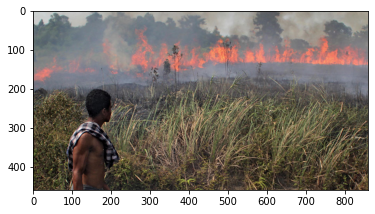

In [7]:
# Investigating to see what the fire images look like

from keras.preprocessing import image
import numpy as np
from matplotlib import pyplot as plt

img_path = 'fire_learning/train/fire/fire.1.png'
img = image.load_img(img_path)
img_tensor = image.img_to_array(img)
#img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)
#plt.imshow(img_tensor[0])
plt.imshow(img_tensor)
plt.show()

# Adapting the Model to the Dataset: #

So far, everything is very similar to the example in the Chollet book but here is where I deviate substantially. Mainly, I dramatically reduce the network size and choose a different metric.

## Less is More ##

>The commented code was my first attempt, based on Chollet's model for differentiating between cats and dogs. Chollet actually had an additionl 2 blocks of convolutions and max pooling. I cut those out and reduced the number of filters in the convolutional layers as well as the number of neurons in the dense layer. My thinking is that pictures of fire are much simpler than pictures of cats and dogs. Faces, in general, have a lot of detail. It makes sense that you would need several convolutional blocks. The first block would learn to detect the different types of edges, a later block would learn to detect more general facial features like eyes and noses etc. 

>Fire, by comparison, is a *lot* simpler. Fire doesn't have complex features like eyes or ears that vary significantly from fire to fire. In fact, I would wager that if all you could do was detect the colour orange, your classifier would be mostly done. But of course, there are other features. We don't want to get cocky and underthink the problem. Sometimes smoke can change the hue of the fire. Houses or flowers in the landscape might be orange. A sunset might be orange. So there needs to be a little bit of sophistication.

>In general, though, I subscribe to the school of thought that neural networks should be as small as possible and I think people often fall into the trap of just adding more layers and more neurons when they get stuck. This is fine if you have the resources to quickly train huge models, but why use all that time and energy when you don't need to? 

> I tried the Chollet model and sure enough it was overfitting (based on the validation and loss plots farther down). So i did a few iterations where I decreased the number of layers, filters and neurons until the loss and validation curves aligned. 

## Other changes ##

>My radical minimalist agenda aside, I made some other changes to Chollet's approach. One of them was using recall as a metric rather than accuracy. My thinking here was that if this model was being deployed, it would probably be deployed to monitor for bushfires/wildfires in remote areas and inform authorities so they can respond quickly. In such a situation, it is *much* better to have a false alarm than to miss a fire that then goes on to spread and cause devastating loss of life. Recall is used to minimise false negatives, so I chose that as my metric. 



In [71]:
# Create the model

from keras import models, layers, optimizers, metrics

'''First attempt
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))'''

model = models.Sequential()
model.add(layers.Conv2D(10, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
#model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[metrics.Recall(), metrics.Precision(), 'acc'])

In [72]:
# Create generators for data augmentation
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(150,150), 
                                                    class_mode='binary', 
                                                    batch_size=20,
                                                    seed=1)

val_generator = val_datagen.flow_from_directory(val_dir, 
                                                target_size=(150,150), 
                                                class_mode='binary', 
                                                batch_size=20,
                                                seed=1)

Found 799 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [73]:
# Train
history = model.fit(train_generator,
                    steps_per_epoch=799//20,
                    epochs=30,
                    validation_data=val_generator,
                    validation_steps=100//20)

model.save('fire_classifier_v9_dropout.h5')

Epoch 1/30
39/39 [==============================] - 35s 866ms/step - loss: 0.4109 - recall_5: 0.5816 - precision_5: 0.6074 - acc: 0.8562 - val_loss: 0.1479 - val_recall_5: 0.9400 - val_precision_5: 0.9592 - val_acc: 0.9500
Epoch 2/30
39/39 [==============================] - 33s 854ms/step - loss: 0.2083 - recall_5: 0.7730 - precision_5: 0.8258 - acc: 0.9294 - val_loss: 0.1434 - val_recall_5: 0.9000 - val_precision_5: 0.9783 - val_acc: 0.9400
Epoch 3/30
39/39 [==============================] - 33s 850ms/step - loss: 0.1059 - recall_5: 0.8592 - precision_5: 0.9457 - acc: 0.9653 - val_loss: 0.1734 - val_recall_5: 1.0000 - val_precision_5: 0.8772 - val_acc: 0.9300
Epoch 4/30
39/39 [==============================] - 33s 851ms/step - loss: 0.1414 - recall_5: 0.8169 - precision_5: 0.8855 - acc: 0.9474 - val_loss: 0.1188 - val_recall_5: 0.9200 - val_precision_5: 0.9787 - val_acc: 0.9500
Epoch 5/30
39/39 [==============================] - 33s 845ms/step - loss: 0.0947 - recall_5: 0.9130 - preci

Note that for the plotting, sometimes the recall and val_recall values get stored in the history dictionary as recall_i and val_recall_i, where i is a number. This happens when I re-train the model. I'm sure there's some resource out there that explains why this happens and how to stop it, but I haven't found it yet. So you may need to change those 2 lines.

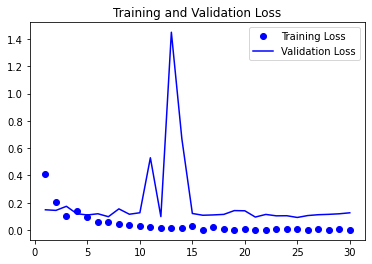

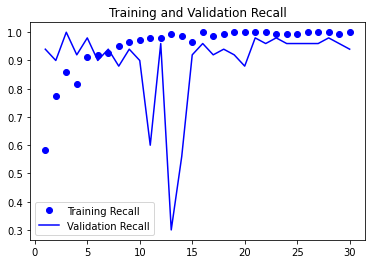

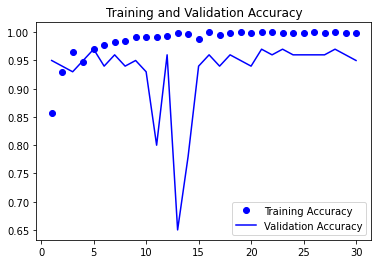

In [75]:
from matplotlib import pyplot as plt

recall = history.history['recall_5']
val_recall = history.history['val_recall_5']
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(recall)+1)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label="Validation Loss")
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure()

plt.plot(epochs, recall, 'bo', label='Training Recall')
plt.plot(epochs, val_recall, 'b-', label="Validation Recall")
plt.title('Training and Validation Recall')
plt.legend()
plt.show()

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label="Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [78]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
test_loss, test_recall, test_precision, test_acc = model.evaluate(test_generator, steps=50) 
print('test recall:', test_recall)
print('test precision:', test_precision)
print('test acc:', test_acc)

Found 100 images belonging to 2 classes.
50/50 [==============================] - 3s 32ms/step - loss: 0.1056 - recall_5: 0.9600 - precision_5: 0.9796 - acc: 0.9700
test recall: 0.9599999785423279
test precision: 0.9795918464660645
test acc: 0.9700000286102295


In [79]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 148, 148, 10)      280       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 74, 74, 10)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 54760)             0         
                                                                 
 dropout (Dropout)           (None, 54760)             0         
                                                                 
 dense_5 (Dense)             (None, 1)                 54761     
                                                                 
Total params: 55,041
Trainable params: 55,041
Non-trainable params: 0
__________________________________________________

In [80]:
# Xception model for comparison
from keras.applications import xception

xception_bf = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
xception_bf.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                   

In [40]:
# Download some images of fires and upload them to the home directory
files.upload()

demo_fire_1.jpg      fire_classifier_v5_smaller.h5  sample_data
demo_fire_2.png      fire_classifier_v7_tiny.h5     sunset_1.jpg
demo_fire_3.jpg      fire_dataset		    sunset_2.jpg
demo_non_fire_1.jpg  fire-dataset.zip		    sunset_3.jpg
demo_non_fire_2.jpg  fire_learning
demo_non_fire_3.jpg  kaggle.json


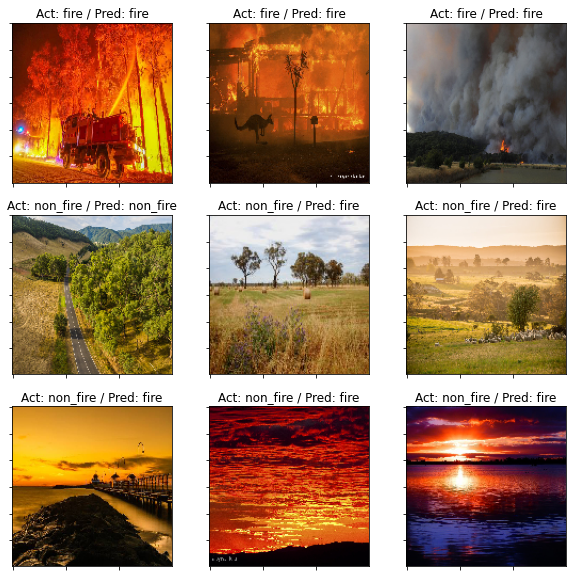

In [76]:
# Create a list of image paths
fire_paths = ['demo_fire_1.jpg', 'demo_fire_2.png', 'demo_fire_3.jpg']
non_fire_paths = [f'demo_non_fire_{i}.jpg' for i in [1,2,3]]
sunset_paths = [f'sunset_{i}.jpg' for i in [1,2,3]]
img_paths = fire_paths + non_fire_paths + sunset_paths

true_labels = ['fire']*3 + ['non_fire']*6
label_map = train_generator.class_indices
inv_map = {value: key for key, value in label_map.items()}

imgs = [image.load_img(img_path, target_size=(150, 150)) for img_path in img_paths]
img_tensor = np.array([image.img_to_array(img) for img in imgs])
#img_tensor = np.expand_dims(img_tensor, axis=0) 
img_tensor /= 255.

y_pred = model.predict(img_tensor) 
y_classes = np.where(y_pred > 0.5, 1,0)

#print(inv_map[y_classes[0]])
#print(label_map)

fig = plt.figure(figsize=(10,10))

for i in range(len(img_tensor)):
  ax = fig.add_subplot(3, 3, i+1)
  ax.imshow(img_tensor[i])
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  ax.set_title(f'Act: {true_labels[i]} / Pred: {inv_map[y_classes[i][0]]}')

plt.show()

In [83]:
files.upload()

Saving green_2.jpg to green_2.jpg


{'green_2.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x02\x02\x02\x03\x02\x02\x02\x03\x03\x03\x03\x04\x06\x04\x04\x04\x04\x04\x08\x06\x06\x05\x06\t\x08\n\n\t\x08\t\t\n\x0c\x0f\x0c\n\x0b\x0e\x0b\t\t\r\x11\r\x0e\x0f\x10\x10\x11\x10\n\x0c\x12\x13\x12\x10\x13\x0f\x10\x10\x10\xff\xdb\x00C\x01\x03\x03\x03\x04\x03\x04\x08\x04\x04\x08\x10\x0b\t\x0b\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\xff\xc0\x00\x11\x08\x02\x1c\x03\xc0\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1d\x00\x00\x02\x03\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x05\x06\x03\x04\x07\x02\x08\x01\x00\t\xff\xc4\x00F\x10\x00\x02\x02\x02\x01\x03\x02\x05\x02\x04\x04\x05\x03\x02\x01\r\x01\x02\x03\x04\x05\x11\x12\x00\x06!\x131\x07\x14"AQ2a\x15#q\x81\x08B\x91\xa1\x16$3R\xb1\xc1\xd1\xf0b\xe1\t%CSr\xf1\x174\

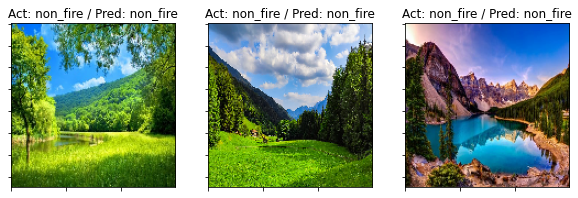

In [84]:
img_paths = ['green_1.jpg', 'green_2.jpg', 'green_3.jpg']

true_labels = ['non_fire']*3

imgs = [image.load_img(img_path, target_size=(150, 150)) for img_path in img_paths]
img_tensor = np.array([image.img_to_array(img) for img in imgs])
img_tensor /= 255.

y_pred = model.predict(img_tensor) 
y_classes = np.where(y_pred > 0.5, 1,0)

fig = plt.figure(figsize=(10,10))

for i in range(len(img_tensor)):
  ax = fig.add_subplot(1, 3, i+1)
  ax.imshow(img_tensor[i])
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  ax.set_title(f'Act: {true_labels[i]} / Pred: {inv_map[y_classes[i][0]]}')

plt.show()